### Faces from Frey and Dueck (2007)

Frey and Dueck use "900 greyscale images extracted from the Olivetti face database." We download the Olivetti faces dataset from scikit-learn, which has a total of 400 samples from 40 distinct subjects.

#### import Affinity Propagation Source Code

In [1]:
AffinityPackage_import_type=['load_installed_package','load_from_directory'][0]

In [2]:
if AffinityPackage_import_type=='load_installed_package':
    """pip install -i https://test.pypi.org/simple/ AffinityPropagation-RezaLevin2020-pkg-DukePhDs==0.0.3"""
    from AffinityPropagation_RezaLevin2020_pkg import Src_AP_V13 as AfP
else:
    """can be found in this repository: https://github.com/MReza89/Stat663_Spring2020_FinalProject_RezaLevin"""
    import Src_AP_V13 as AfP # requires to have Src_AP_V13.py in the current directory

#### import libraries related to testing

In [3]:
import sklearn.cluster as cluster
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import datasets
#from sklearn_extra.cluster import KMedoids
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
import time

In [4]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

##### Data 

In [5]:
from sklearn.datasets import fetch_olivetti_faces

In [6]:
faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\mrm132\scikit_learn_data


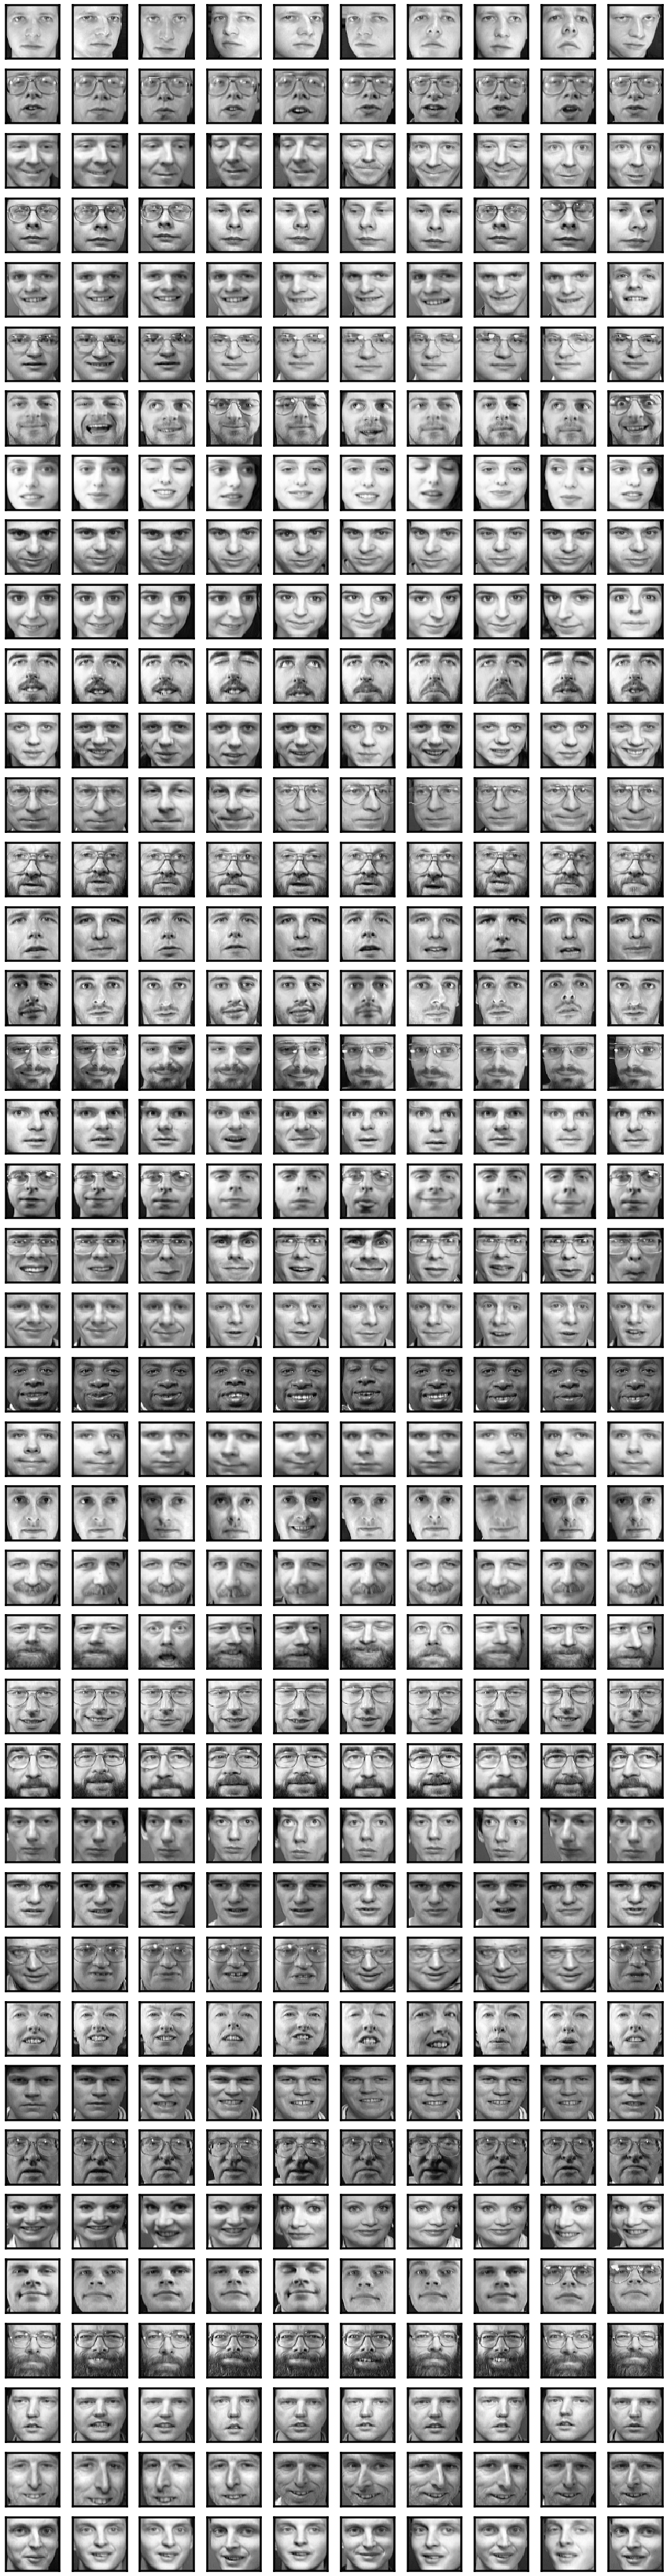

In [7]:
rows = 40
cols = 10

fig, ax = plt.subplots(rows, cols, figsize = (15, 1.5*rows))
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(faces.images[i*10 + j], cmap='gray')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)

In [8]:
fig.savefig('all_faces.png')

Using our algorithm to cluster

In [9]:
%%time
pref = -210 # this gives us exactly 40 classes
exemplars,labels,Cluster_Centers,last_iteration=AfP.affinity_propagation(faces.data,preference=pref,max_iter=200,Plot_Clusters=False)
print("Number of exemplars: %i" % len(exemplars))

[ 17  59  60  62  74  79  83 105 114 118 139 149 151 165 177 182 187 206
 218 236 238 245 250 262 274 275 291 302 308 319 322 335 345 351 360 363
 376 380 391 396] 64
Number of exemplars: 40
Wall time: 736 ms


In [10]:
exemplars

array([ 17,  59,  60,  62,  74,  79,  83, 105, 114, 118, 139, 149, 151,
       165, 177, 182, 187, 206, 218, 236, 238, 245, 250, 262, 274, 275,
       291, 302, 308, 319, 322, 335, 345, 351, 360, 363, 376, 380, 391,
       396], dtype=int64)

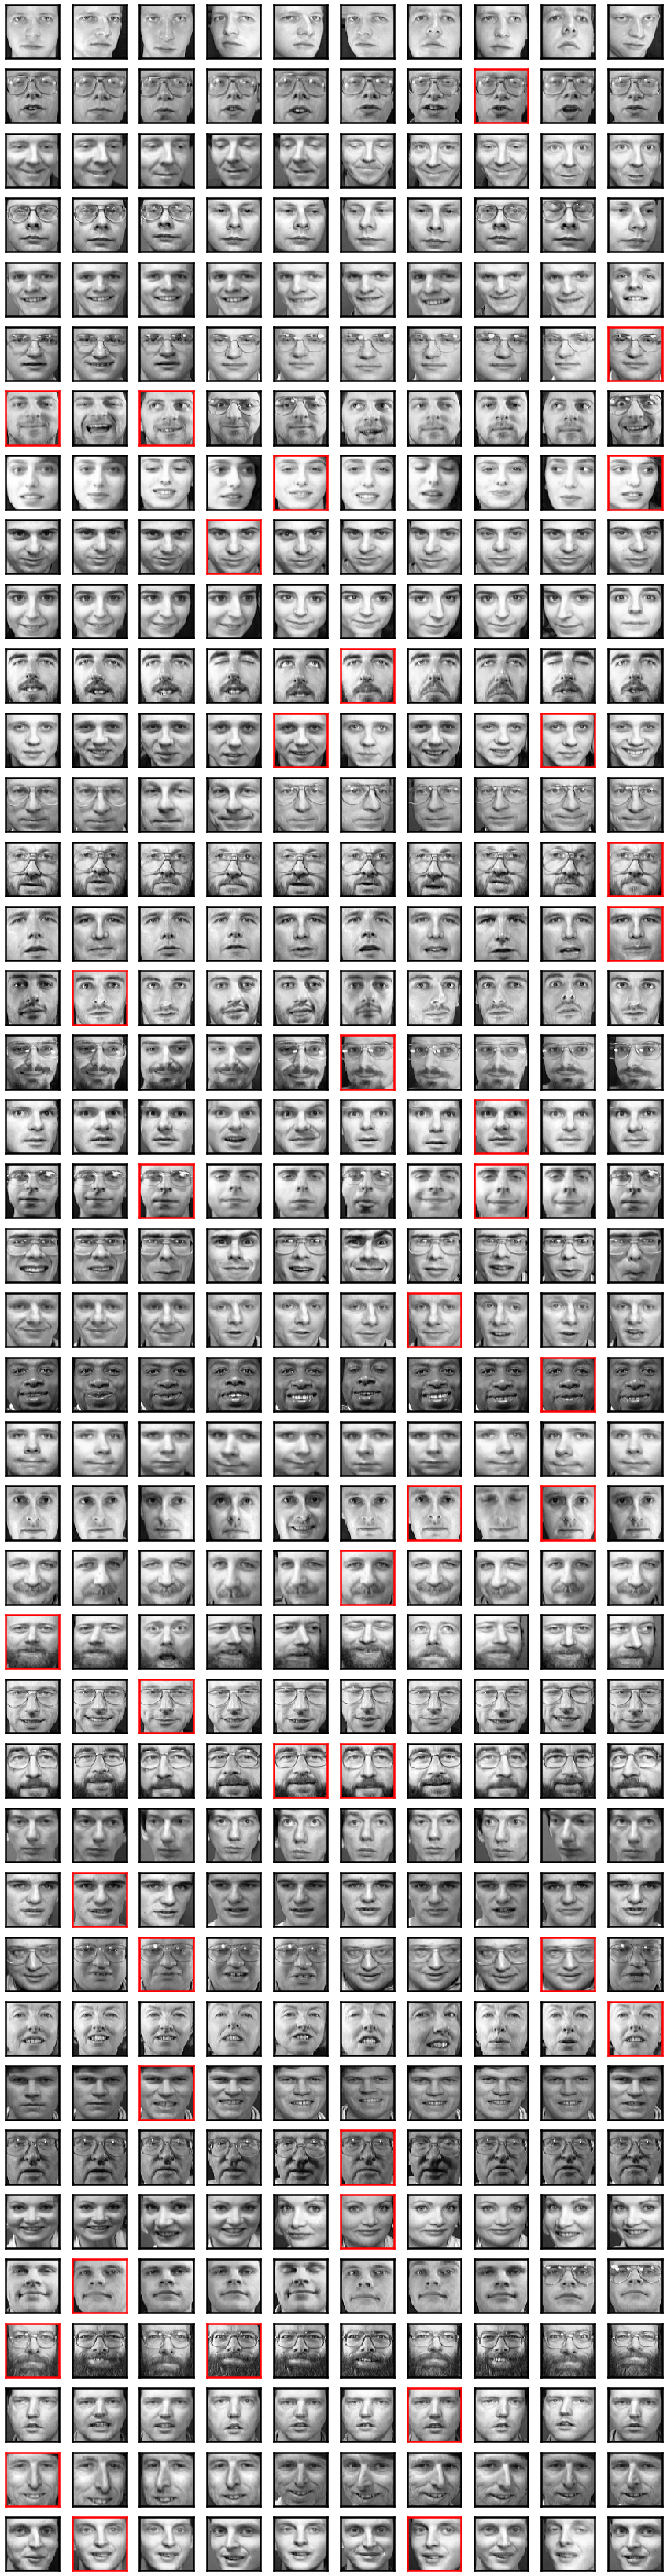

In [11]:
# Plot faces with exemplars highlighted
rows = 40
cols = 10

fig, ax = plt.subplots(rows, cols, figsize = (15, 1.5*rows))
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(faces.images[i*10 + j], cmap='gray')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        if i*10+j in exemplars:
            for spine in ax[i,j].spines.values():
                spine.set_edgecolor('red')

In [12]:
fig.savefig('faces_exemplars_AP.png')

In [13]:
# Match accuracy

# array of image features (4096 pixels each) with true label
faces_targets = np.c_[faces.data, faces.target]

# add a column of the class of the exemplar each face is assigned to
exemplar_class = faces_targets[labels, 4096]
faces_targets = np.c_[faces_targets, exemplar_class]

# See how many of these is a correct match (i.e. true label vs. exemplar label)
true_label = faces_targets[:,4096]
exemplar_label = faces_targets[:,4097]
np.sum(true_label == exemplar_label)/len(faces.data)

0.65

In [15]:
# Mean square error

sim = []

# for each image
for i in range(400):
    # exemplar image
    exemplar_image = labels[i]
    # exemplar image data
    exemplar_data = faces.data[exemplar_image]
    image_data = faces.data[i]
    # calculate squared error
    error = AfP.Similarity(image_data, exemplar_data)
    sim.append(error)

np.mean(sim)

-44.559208

Using K-Means

In [16]:
km_labels = np.zeros((100,40))
km_labels[0,:] = np.arange(40)
km_labels

array([[ 0.,  1.,  2., ..., 37., 38., 39.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

####  Compareing with Skit-Learn

In [24]:
def Sklearn_clusters(data, algorithm, args, kwds, Plot_Clusters=True,**plot_kwds):
    """ a function for performing clustering with Skit-Learn library"""
    
    start_time = time.time()
    #######
    #labels = algorithm(*args, **kwds).fit_predict(data)
    model=algorithm(*args, **kwds).fit(data)
    labels=model.labels_
    if algorithm==cluster.AffinityPropagation:
        cluster_centers_indices=model.cluster_centers_indices_
        cluster_centers=model.cluster_centers_
    if algorithm==cluster.KMeans:
        cluster_centers=model.cluster_centers_
#     if algorithm==KMedoids:
#         cluster_centers_indices=model.medoid_indices_
#         cluster_centers=model.cluster_centers_
    ####
    end_time = time.time()
    
    if Plot_Clusters==True:
        plot_clusters(data,gapless_labels=labels,**plot_kwds)
   
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if algorithm==cluster.AffinityPropagation:
        return labels,cluster_centers_indices,cluster_centers
    if algorithm==cluster.KMeans:
        return labels,cluster_centers
#     if algorithm==KMedoids:
#         return labels,cluster_centers_indices,cluster_centers
    else:
        return labels
    

    #plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
def plot_clusters(data,gapless_labels,**plot_kwds):
    fig = plt.figure(figsize=(15, 5))
    palette = sns.color_palette(palette='deep', n_colors=np.unique(gapless_labels).max() + 1)
    
    colors = [palette[x] for x in gapless_labels] #[palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.show()    

In [26]:
%%time
n_clusters = 40
runs = 100

args = ()
kwds = {'n_clusters' : n_clusters}

km_labels, km_cluster_centers = Sklearn_clusters(faces.data, cluster.KMeans, args,kwds,Plot_Clusters=False)

Clustering took 5.46 s
Wall time: 5.46 s


In [27]:
# running KMeans 100 times
n_clusters = 40
runs = 100

args = ()
kwds = {'n_clusters' : n_clusters}

km_labels_list = []
km_cluster_centers_list = []
for i in range(runs):
    km_labels, km_cluster_centers = Sklearn_clusters(faces.data, cluster.KMeans, args, kwds, Plot_Clusters=False)
    km_labels_list.append(km_labels)
    km_cluster_centers_list.append(km_cluster_centers_list)

Clustering took 5.35 s
Clustering took 5.61 s
Clustering took 5.34 s
Clustering took 5.43 s
Clustering took 5.89 s
Clustering took 5.60 s
Clustering took 5.82 s
Clustering took 5.68 s
Clustering took 5.66 s
Clustering took 5.67 s
Clustering took 5.60 s
Clustering took 5.49 s
Clustering took 5.32 s
Clustering took 5.42 s
Clustering took 5.44 s
Clustering took 8.61 s
Clustering took 6.36 s
Clustering took 7.52 s
Clustering took 6.08 s
Clustering took 5.61 s
Clustering took 5.62 s
Clustering took 5.36 s
Clustering took 5.34 s
Clustering took 5.38 s
Clustering took 5.29 s
Clustering took 5.61 s
Clustering took 5.40 s
Clustering took 5.31 s
Clustering took 5.35 s
Clustering took 5.62 s
Clustering took 5.72 s
Clustering took 5.28 s
Clustering took 6.11 s
Clustering took 5.46 s
Clustering took 5.63 s
Clustering took 5.75 s
Clustering took 6.43 s
Clustering took 6.82 s
Clustering took 7.15 s
Clustering took 5.55 s
Clustering took 5.43 s
Clustering took 5.32 s
Clustering took 5.34 s
Clustering 

In [29]:
# Mean square error
km_sim = np.arange(runs, dtype=float)

# for each run
for run in range(runs):
    temp = []
    # for each image
    for i in range(400):
        # cluster center assigned to image i
        cluster_center = km_labels_list[run][i]
        # cluster center image data
        cluster_center_data = faces.data[cluster_center]
        image_data = faces.data[i]
        # calculate squared error
        error = AfP.Similarity(image_data, cluster_center_data)
        temp.append(error)
    km_sim[run] = np.mean(temp)

km_sim

array([-138.37550354, -154.93496704, -142.26274109, -158.44386292,
       -159.89115906, -155.61810303, -144.17192078, -151.07765198,
       -148.0761261 , -152.31510925, -159.72834778, -160.83633423,
       -159.54371643, -163.76234436, -156.41340637, -154.5849762 ,
       -159.46043396, -157.90797424, -150.46966553, -147.34750366,
       -149.08805847, -150.28598022, -140.27935791, -143.09712219,
       -151.99691772, -155.06703186, -153.31297302, -150.83398438,
       -155.62463379, -157.91101074, -150.54203796, -157.82426453,
       -151.75300598, -148.16920471, -144.57263184, -143.91943359,
       -146.33970642, -148.39089966, -158.41523743, -157.07504272,
       -160.26573181, -160.23100281, -163.25424194, -151.14186096,
       -157.26695251, -152.2519989 , -151.9932251 , -145.62675476,
       -159.34405518, -162.69898987, -162.28503418, -149.8263092 ,
       -146.79681396, -158.52206421, -143.99440002, -147.50012207,
       -155.55841064, -150.31964111, -164.80361938, -145.44219

In [30]:
# the best run of KMeans and avg. MSE of KMeans
np.max(km_sim), np.mean(km_sim)

(-135.45230102539062, -152.90123458862305)

In [31]:
# Comparing KMeans with AP

# 15 images withthe worst square error from cluster center/exemplar under either method
AP_min_idx = np.argsort(sim)[:15]
KM_min_idx = np.argsort(km_sim)[:15]

AP_min_idx, KM_min_idx

(array([354, 350, 325,  78, 150, 340, 316,  93,  62,  92, 341, 167,  70,
        155,   8], dtype=int64),
 array([58, 13, 62, 76, 42, 49, 50, 88, 86, 11, 40, 41,  4, 10, 12],
       dtype=int64))